This notebook lays out the model training process for ConvLSTM, including loading the data, hyperparameter setting, and customizing the loss function.

The ConvLSTM implementation is from [GeoTorchAI](https://kanchanchy.github.io/geotorchai/index.html) for experimentation. The code for training the ConvLSTM is adapted from [here](https://kanchanchy.github.io/geotorchai/coding_examples.html). See [here](https://kanchanchy.github.io/geotorchai/installation.html) for instructions on how to install GeoTorchAI.

In [55]:
import os
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from geotorchai.models.grid import ConvLSTM

import matplotlib.pyplot as plt

# autoreload modules when code is changed
%load_ext autoreload
%autoreload 2

# load ImageFolder.py from scripts folder
import sys
sys.path.append('../scripts/')
from ImageFolder import ImageFolder, ImageDataset
from LossFunctions import SSIMLoss, PhaseFieldLoss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize device with GPU
In order to perform deep learning with GPU, we need to check whether GPU is available at first. We will initialize the device with GPU if it is available. Otherwise, CPU will be used as the default device.

In [25]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

device = get_device()
print(device)

mps


## Define method for calculating three types of errors: MSE, MAE, RMSE

In [26]:
def compute_errors(preds, y_true):
    pred_mean = preds[:, 0:2]
    diff = y_true - pred_mean

    mse = np.mean(diff ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(diff))

    return mse, mae, rmse             

## Define method for calculating validation loss

In [73]:
def get_validation_loss(model, val_generator, criterion, device, len_history):
    model.eval()
    mean_loss = []
    for i, sample in enumerate(val_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        # might need to set this to just outputs if we are using just mseLoss
        loss=criterion(outputs[:, len_history - 1:len_history, :, :, :], Y_batch).item()
        mean_loss.append(loss)

    mean_loss = np.mean(mean_loss)
    return mean_loss

## Define model class

In [28]:
class GeoTorchConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers):
        super().__init__()
        self.lstm = ConvLSTM(input_dim=input_size, 
                             hidden_dim=hidden_dim, 
                             num_layers=num_layers)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        return lstm_out

## Initialize parameters

In [39]:
# model parameters
input_dim = 1
input_width = 128
input_height = 128
hidden_layer_sizes = [256, 256, 1]
num_layers = len(hidden_layer_sizes)

# sequence lengths
len_history = 5
len_predict = 1

# training parameters
epoch_nums = 40
learning_rate = 0.002
batch_size = 4
params = {'batch_size': batch_size, 'shuffle': False, 'drop_last':False, 'num_workers': 2}

# Sets the model output directory
checkpoint_dir = '../models'
model_name = 'convlstm'
model_dir = checkpoint_dir + "/" + model_name
os.makedirs(model_dir, exist_ok=True)

# For loading pretrained model if available
initial_checkpoint = model_dir + '/model.best.pth'
LOAD_INITIAL = False

## Load Data

In [58]:
# Set data paths
data_root = '../data/cracks_s_nb'
train_path = os.path.join(data_root, "train")
test_path = os.path.join(data_root, "test")
val_path = os.path.join(data_root, "val")

In [59]:
train = ImageFolder(root=train_path, transform=transforms.ToTensor())
test = ImageFolder(root=test_path, transform=transforms.ToTensor())
val = ImageFolder(root=val_path, transform=transforms.ToTensor())

train.set_sequential_representation(history_length=len_history, predict_length=len_predict)
test.set_sequential_representation(history_length=len_history, predict_length=len_predict)
val.set_sequential_representation(history_length=len_history, predict_length=len_predict)

train_generator = DataLoader(ImageDataset(train), **params)
test_generator = DataLoader(ImageDataset(test), **params)
val_generator = DataLoader(ImageDataset(val), **params)

In [60]:
train.__getitem__(0).shape

torch.Size([1, 128, 128])

## Define method for initializing model and perform training and testing

In [74]:
def createModelAndTrain(loss_fn):
    device = get_device()

    model = GeoTorchConvLSTM(input_dim, hidden_layer_sizes, num_layers)

    if LOAD_INITIAL:
        model.load_state_dict(torch.load(initial_checkpoint, map_location=lambda storage, loc: storage))

    loss_fn = loss_fn
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    loss_fn.to(device)

    min_val_loss = None
    for e in range(epoch_nums):
        for i, sample in enumerate(train_generator):
            X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
            Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = loss_fn(outputs[:, len_history - 1:len_history, :, :, :], Y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = get_validation_loss(model, val_generator, loss_fn, device, len_history)
        
        print('Epoch [{}/{}], Train Loss: {:.4f}'.format(e + 1, epoch_nums, loss.item()), 'Mean Val Loss:', val_loss)

        if min_val_loss == None or val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), initial_checkpoint)
            print('best model saved!')

    model.load_state_dict(torch.load(initial_checkpoint, map_location=lambda storage, loc: storage))
    model.eval()
    rmse_list = []
    mse_list = []
    mae_list = []
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        mse, mae, rmse = compute_errors(outputs[:, len_history - 1:len_history, :, :, :].cpu().data.numpy(),
                                        Y_batch.cpu().data.numpy())

        rmse_list.append(rmse)
        mse_list.append(mse)
        mae_list.append(mae)

    rmse = np.mean(rmse_list)
    mse = np.mean(mse_list)
    mae = np.mean(mae_list)

    print("\n************************")
    print("Test ConvLSTM model with Crack Dataset:")
    print('Test mse: %.6f mae: %.6f rmse (norm): %.6f' % (
    mse, mae, rmse))

## Define loss functions

In [61]:
# Set loss functions
loss_mse = nn.MSELoss()
loss_ssim = SSIMLoss()
loss_phasefield = PhaseFieldLoss()

## Call model training and testing from main

In [62]:
if __name__ == '__main__':
    try:
        createModelAndTrain(loss_fn=loss_mse)
        # createModelAndTrain(loss_fn=loss_ssim)
        # createModelAndTrain(loss_fn=loss_phasefield)
    finally:
        # Clear the memory
        torch.cuda.empty_cache()

/Users/jenny/miniconda3/envs/crack/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1, 128, 128])) that is different to the input size (torch.Size([4, 5, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jenny/miniconda3/envs/crack/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1, 128, 128])) that is different to the input size (torch.Size([1, 5, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Train Loss: 0.0004 Mean Val Loss: 0.002265031601732167
best model saved!
Epoch [2/10], Train Loss: 0.0003 Mean Val Loss: 0.002023854606355039
best model saved!
Epoch [3/10], Train Loss: 0.0003 Mean Val Loss: 0.0018344991392670916
best model saved!
Epoch [4/10], Train Loss: 0.0002 Mean Val Loss: 0.0016983319924642833
best model saved!
Epoch [5/10], Train Loss: 0.0002 Mean Val Loss: 0.0015904679983997573
best model saved!
Epoch [6/10], Train Loss: 0.0002 Mean Val Loss: 0.0015154802240431309
best model saved!
Epoch [7/10], Train Loss: 0.0002 Mean Val Loss: 0.0014616223499895288
best model saved!
Epoch [8/10], Train Loss: 0.0002 Mean Val Loss: 0.0014207758851206074
best model saved!
Epoch [9/10], Train Loss: 0.0002 Mean Val Loss: 0.0013873682429011052
best model saved!
Epoch [10/10], Train Loss: 0.0002 Mean Val Loss: 0.0013590688647057575
best model saved!

************************
Test ConvLSTM model with Crack Dataset:
Test mse: 0.000356 mae: 0.003303 rmse (norm): 0.017944


In [75]:
if __name__ == '__main__':
    try:
        # createModelAndTrain(loss_fn=loss_mse)
        createModelAndTrain(loss_fn=loss_ssim)
        # createModelAndTrain(loss_fn=loss_phasefield)
    finally:
        # Clear the memory
        torch.cuda.empty_cache()

Epoch [1/10], Train Loss: 0.1037 Mean Val Loss: 0.14431150601460382
best model saved!
Epoch [2/10], Train Loss: 0.0222 Mean Val Loss: 0.037553525888002835
best model saved!
Epoch [3/10], Train Loss: 0.0193 Mean Val Loss: 0.028664781497075006
best model saved!
Epoch [4/10], Train Loss: 0.0185 Mean Val Loss: 0.027186833895169772
best model saved!


In [ ]:
if __name__ == '__main__':
    try:
        # createModelAndTrain(loss_fn=loss_mse)
        # createModelAndTrain(loss_fn=loss_ssim)
        createModelAndTrain(loss_fn=loss_phasefield)
    finally:
        # Clear the memory
        torch.cuda.empty_cache()

Predicted Image Shape: torch.Size([4, 1, 1, 128, 128])
Ground Truth Shape: torch.Size([4, 1, 1, 128, 128])
Grad Phi X Shape: torch.Size([4, 1, 0, 128, 128])
Grad Phi Y Shape: torch.Size([4, 0, 1, 128, 128])
PDE Residual Shape: torch.Size([4, 0, 0, 128, 128])
Predicted Image Shape: torch.Size([4, 1, 1, 128, 128])
Ground Truth Shape: torch.Size([4, 1, 1, 128, 128])
Grad Phi X Shape: torch.Size([4, 1, 0, 128, 128])
Grad Phi Y Shape: torch.Size([4, 0, 1, 128, 128])
PDE Residual Shape: torch.Size([4, 0, 0, 128, 128])
Predicted Image Shape: torch.Size([4, 1, 1, 128, 128])
Ground Truth Shape: torch.Size([4, 1, 1, 128, 128])
Grad Phi X Shape: torch.Size([4, 1, 0, 128, 128])
Grad Phi Y Shape: torch.Size([4, 0, 1, 128, 128])
PDE Residual Shape: torch.Size([4, 0, 0, 128, 128])
Predicted Image Shape: torch.Size([4, 1, 1, 128, 128])
Ground Truth Shape: torch.Size([4, 1, 1, 128, 128])
Grad Phi X Shape: torch.Size([4, 1, 0, 128, 128])
Grad Phi Y Shape: torch.Size([4, 0, 1, 128, 128])
PDE Residual Sha

/Users/jenny/miniconda3/envs/crack/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1, 128, 128])) that is different to the input size (torch.Size([4, 5, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (3) must match the size of tensor b (0) at non-singleton dimension 1

# Visualize Predictions

In [63]:
# Load model from checkpoint file in models folder
model = GeoTorchConvLSTM(input_dim, hidden_layer_sizes, num_layers)
model.load_state_dict(torch.load(initial_checkpoint))
model.to(device)

GeoTorchConvLSTM(
  (lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): _ConvLSTMCell(
        (conv): Conv2d(257, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (1): _ConvLSTMCell(
        (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (2): _ConvLSTMCell(
        (conv): Conv2d(257, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
  )
)

In [69]:
# Write a function to use plt to show the model predictions
def show_predictions(model, test_generator, device, num_samples=5):
    model.eval()
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        break

    for i in range(num_samples):
        try:
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(outputs[i, len_history - 1, 0, :, :].cpu().data.numpy(), cmap='gray')
            plt.axis('off')
            plt.title("Predicted")
            plt.subplot(1, 2, 2)
            plt.imshow(np.squeeze(Y_batch[i, 0, :, :].cpu().data.numpy()), cmap='gray')
            plt.axis('off')
            plt.title("Ground Truth")
            plt.show()
        except:
            print(f"sample {i} failed to plot")
            continue

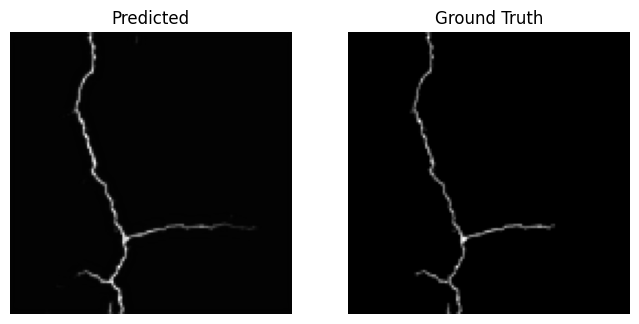

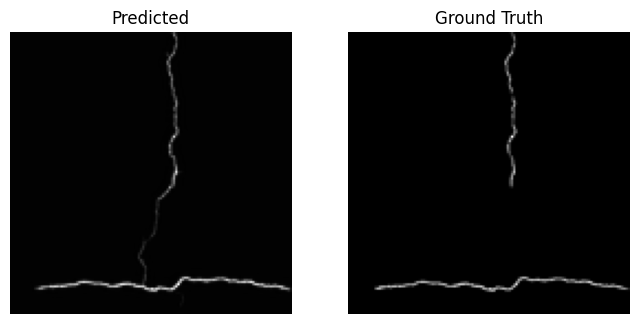

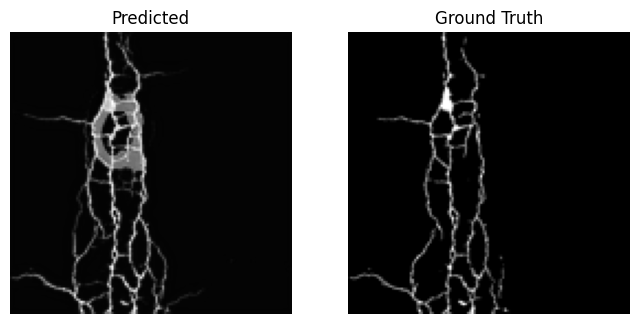

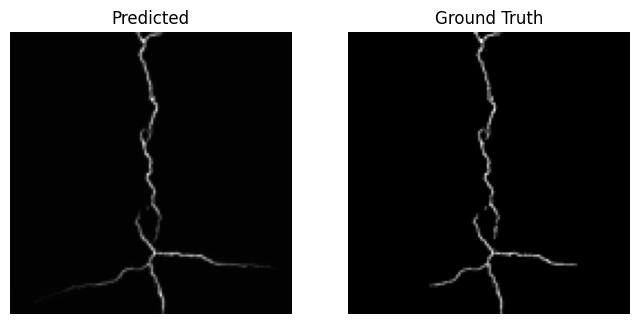

sample 4 failed to plot
sample 5 failed to plot
sample 6 failed to plot
sample 7 failed to plot
sample 8 failed to plot
sample 9 failed to plot


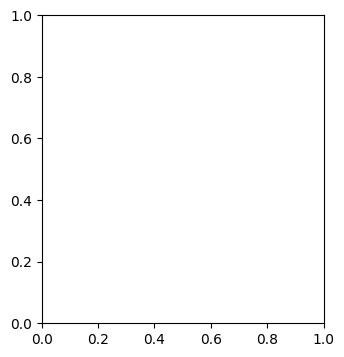

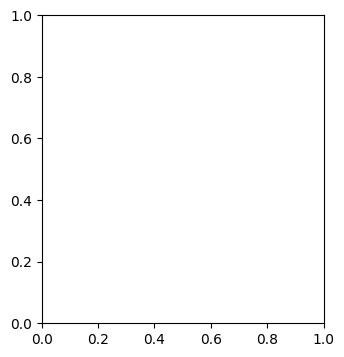

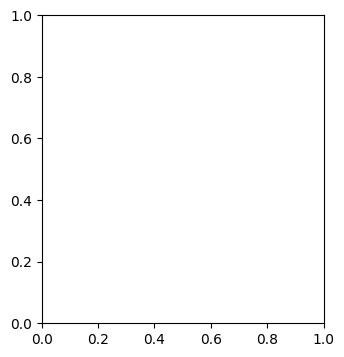

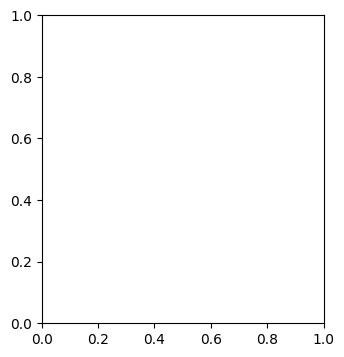

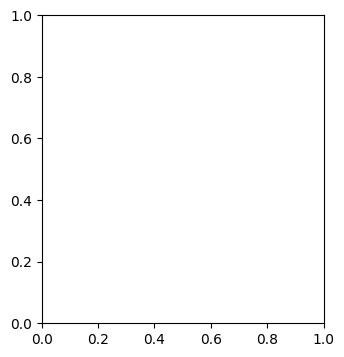

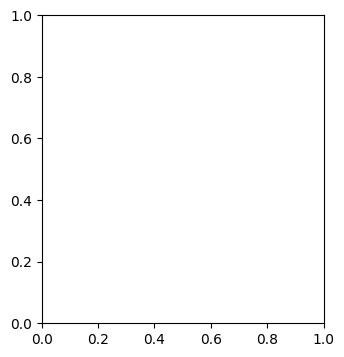

In [70]:
show_predictions(model, test_generator, device, num_samples=10)